# 1. Introduction

This notebook processes audio files containing anemonefish calls, converting them into spectrograms. The goal is to visualize the frequency content of these calls over time, similar to Audacity's spectrogram view, focusing on the 0-2000Hz range. Spectrograms will be saved as image files.

# 2. Setup and Imports

This section imports the necessary Python libraries for audio processing, numerical operations, plotting, and file system interactions.

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from IPython.display import Image, display
from tqdm import tqdm

# 3. Configuration

Define the input and output directories, and parameters for spectrogram generation.
- `AUDIO_DIR`: Path to the directory containing your audio files (e.g., `.wav`).
- `SPECTROGRAM_DIR`: Path to the directory where generated spectrogram images will be saved.
- `FMAX_HZ`: Maximum frequency (in Hz) to display on the spectrogram.
- `N_FFT`: FFT window size. This affects the frequency resolution.
- `HOP_LENGTH`: Hop length for STFT. This affects the time resolution.

In [2]:
# --- Configuration ---
AUDIO_DIR = Path('/Volumes/InsightML/NAS/3_Lucia_Yllan/Clown_Fish_Acoustics/data/1_binary_training_data/audio_files/noise') # IMPORTANT: Change if your audio files are elsewhere
SPECTROGRAM_DIR = Path('/Volumes/InsightML/NAS/3_Lucia_Yllan/Clown_Fish_Acoustics/data/1_binary_training_data/spectograms/noise')
FMAX_HZ = 2000  # Max frequency for anemonefish calls
N_FFT = 1024  # FFT window size
HOP_LENGTH = N_FFT // 4  # Hop length, typically 1/4 or 1/2 of N_FFT

WIDTH_PIXELS = 256  # Width in pixels
HEIGHT_PIXELS = 256  # Height in pixels

# Create output directory if it doesn't exist
SPECTROGRAM_DIR.mkdir(parents=True, exist_ok=True)

print(f"Audio input directory: {AUDIO_DIR.resolve()}")
print(f"Spectrogram output directory: {SPECTROGRAM_DIR.resolve()}")
if not AUDIO_DIR.exists():
    print(f"WARNING: Audio directory {AUDIO_DIR} does not exist. Please check the path.")

Audio input directory: /Volumes/InsightML/NAS/3_Lucia_Yllan/Clown_Fish_Acoustics/data/1_binary_training_data/audio_files/noise
Spectrogram output directory: /Volumes/InsightML/NAS/3_Lucia_Yllan/Clown_Fish_Acoustics/data/1_binary_training_data/spectograms/noise


# 4. Function to Generate and Save Spectrogram

This function takes an audio file path, loads the audio, computes its spectrogram, and saves it as a PNG image.

In [3]:
def create_and_save_spectrogram(audio_path, output_image_path, sr_target=None, n_fft=N_FFT, hop_length=HOP_LENGTH, fmax=FMAX_HZ):
    """
    Generates a spectrogram from an audio file and saves it as an image
    suitable for CNN input (no axes, labels, colorbar).

    Args:
        audio_path (Path or str): Path to the input audio file.
        output_image_path (Path or str): Path to save the output spectrogram image.
        sr_target (int, optional): Target sampling rate. If None, uses native.
                                   Consider sr_target= (e.g., 2 * fmax, so 4000 or 8000 for fmax=2000Hz).
        n_fft (int): FFT window size.
        hop_length (int): Hop length for STFT.
        fmax (int): Maximum frequency relevant for the STFT and display.
    """
    try:
        # Load audio file
        y, sr = librosa.load(audio_path, sr=sr_target)

        # Compute Short-Time Fourier Transform (STFT)
        # The STFT will consider frequencies up to sr/2.
        # We are interested in fmax, so ensure sr is adequate.
        # If sr_target is set (e.g., 4000Hz for fmax=2000Hz), this is fine.
        D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)

        # Convert amplitude to decibels
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

        # Create a figure and axes with specific DPI for desired resolution
        dpi = 100  # Dots per inch - adjust as needed
        
        # Convert pixels to inches for figsize
        width_inches = WIDTH_PIXELS / dpi
        height_inches = HEIGHT_PIXELS / dpi
        
        fig, ax = plt.subplots(1, figsize=(width_inches, height_inches), dpi=dpi)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1) # Remove padding around the plot

        # Plot spectrogram
        # We use librosa.display.specshow which is convenient, but ensure it doesn't add extra whitespace.
        # The actual frequency range of S_db depends on sr and n_fft.
        # We'll plot the relevant portion up to fmax.
        img = librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis=None, y_axis=None, fmax=fmax, ax=ax)
        
        # Ensure the y-axis is limited to fmax if specshow's fmax isn't perfectly cropping the data display.
        # This cuts the *displayed* data, not the underlying STFT calculation.
        num_frequency_bins = S_db.shape[0]
        if fmax is not None and sr is not None:
            # Calculate the bin index corresponding to fmax
            fmax_bin = int(fmax / (sr / 2.0) * num_frequency_bins)
            if fmax_bin < num_frequency_bins : # Ensure fmax_bin is within bounds
                 ax.set_ylim(0, fmax_bin) # Set y-limit in terms of bins for specshow
            # If fmax is higher than Nyquist, librosa handles it by showing up to Nyquist.

        # Turn off all axes, labels, titles, colorbar
        ax.axis('off')
        
        # Save the figure at the specified resolution
        plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0, dpi=dpi)
        plt.close(fig) # Close the figure to free memory
        
        return True
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return False

# Example usage (optional, will be used in the next step)
# test_audio_file = AUDIO_DIR / 'your_sample_audio.wav' # Replace with an actual file name
# test_output_image = SPECTROGRAM_DIR / 'your_sample_audio_spectrogram.png'
# if test_audio_file.exists():
#    create_and_save_spectrogram(test_audio_file, test_output_image, fmax=2000)
# else:
#    print(f"Test audio file {test_audio_file} not found. Skipping example generation here.")

# 5. Process Audio Files in Directory

This section iterates through all `.wav` audio files in the specified `AUDIO_DIR`, generates a spectrogram for each, and saves it to the `SPECTROGRAM_DIR`.

Processing audio files from: /Volumes/InsightML/NAS/3_Lucia_Yllan/Clown_Fish_Acoustics/data/1_binary_training_data/audio_files/noise
Found 36376 .wav files to process.


  1%|          | 288/36376 [00:07<14:57, 40.20it/s] 


KeyboardInterrupt: 

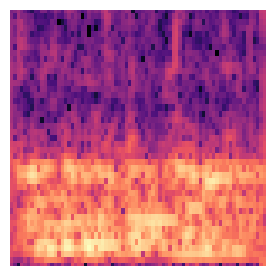

In [4]:
processed_files = 0
error_files = 0
example_spectrogram_path = None

if AUDIO_DIR.exists() and AUDIO_DIR.is_dir():
    print(f"Processing audio files from: {AUDIO_DIR}")
    # Look for .wav files, but you can add other extensions like '.mp3'
    audio_files = [f for f in AUDIO_DIR.glob('*.wav') if not f.name.startswith('.')]

    # TEMP: Remove the first 4 and last 4 files
    audio_files = audio_files[4:-4]

    if not audio_files:
        print(f"No .wav files found in {AUDIO_DIR}. Please check the directory and file extensions.")
    else:
        print(f"Found {len(audio_files)} .wav files to process.")

    for audio_file_path in tqdm(audio_files):
        # print(f"Processing: {audio_file_path.name}...")
        output_filename = audio_file_path.stem + '_spectrogram.png'
        output_image_path = SPECTROGRAM_DIR / output_filename
        
        if create_and_save_spectrogram(audio_file_path, output_image_path, fmax=2000):
            processed_files += 1
            if example_spectrogram_path is None: # Store path of the first successfully processed file
                example_spectrogram_path = output_image_path
        else:
            error_files += 1
            
    print(f"\n--- Processing Complete ---")
    print(f"Successfully processed and saved {processed_files} spectrograms.")
    if error_files > 0:
        print(f"Encountered errors for {error_files} files.")
    if example_spectrogram_path:
        print(f"An example spectrogram: {example_spectrogram_path}")
else:
    print(f"Audio directory {AUDIO_DIR} does not exist or is not a directory. Please check the 'AUDIO_DIR' path in Cell 5.")


# 6. Display an Example Spectrogram

If spectrograms were generated, this section displays the first one created.

In [ ]:
if example_spectrogram_path and example_spectrogram_path.exists():
    print(f"Displaying example: {example_spectrogram_path}")
    display(Image(filename=example_spectrogram_path, width=800))
elif processed_files > 0 :
     print("An example spectrogram was generated, but its path was not captured. Check the SPECTROGRAM_DIR.")
else:
    print("No spectrograms were generated or found to display.")